# Face Classification and Verification
This code deals witt the problems  of `classification` and `verification` with a popular problem space of `face`

## Datasets 
- Load the data from the drive [link](https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 


In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# because the warnings were really annoying :P 
import warnings
warnings.filterwarnings("ignore")

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should we take grayscale images? Or rgb images? We can choose whichever gives better representation for classification. 

In [2]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [3]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [4]:
# Loading the dataset
# eg.
dirpath = './dataset/IIIT-CFW/'
dirpath2 = './dataset/IMFDB/'
dirpath3 = './dataset/Yale_face_database/'

X,y = load_data(dirpath)
X_movie,y_movie = load_data(dirpath2)
X_yale,y_yale = load_data(dirpath3)

N,H,W = X.shape[0:3]
N2,H2,W2 = X_movie.shape[0:3]
N3,H3,W3 = X_yale.shape[0:3]

C = 1 if opt['is_grayscale'] else X.shape[3]
C2 = 1 if opt['is_grayscale'] else X_movie.shape[3]
C3 = 1 if opt['is_grayscale'] else X_yale.shape[3]

FileNotFoundError: [Errno 2] No such file or directory: './dataset/IIIT-CFW/'

In [5]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

NameError: name 'y' is not defined

# Features
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**


In [9]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

NameError: name 'X' is not defined

In [267]:
# Flattening the other datasets as well to apply PCA
X_movie = X_movie.reshape((N2,H2*W2*C2))
X_yale = X_yale.reshape((N3,H3*W3*C3))
print(X_movie.shape)

(400, 3072)


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 

In [268]:
# Get PCA of K dimension using the top eigen vectors 
def get_pca(X,k):
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k, pca

###  2. Kernel Face:
We use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. 


In [269]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.


In [270]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        X => Your data flattened to D dimension
        k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [271]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        X => Your data flattened to D dimension
        k => Number of components
        kernel ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). HEre is the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [272]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [273]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features


- Eigen faces are the set of eigen vectors of the covariance matrix of the data face images, that are used in the problem of human face recognition. They are essentially the "faces" that are **RECONSTRUCTED** after applying dimensionality reduction tchniques like PCA, on the given data set. 

- So we apply a feature transformation on the data set to reduce the dimensionality of the images. Then, when we reconstruct it back with the help of the eigen vectors, we get the "reconstructed faces" or the "eigen faces" back. Hence these eigen vectors are called eigen faces. 

We first apply PCA on the datasets

In [274]:
# Compute your features 
X_pca, pca = get_pca(X,45)
X_movie_pca, pca2 = get_pca(X_movie,45)
X_yale_pca, pca3 = get_pca(X_yale,45)

print(X_pca.shape)
print(X_movie_pca.shape)
print(X_yale_pca.shape)

(672, 45)
(400, 45)
(165, 45)


Creating scatter plots for the transformed data of all datasets

Text(0.5,0.92,'Yale')

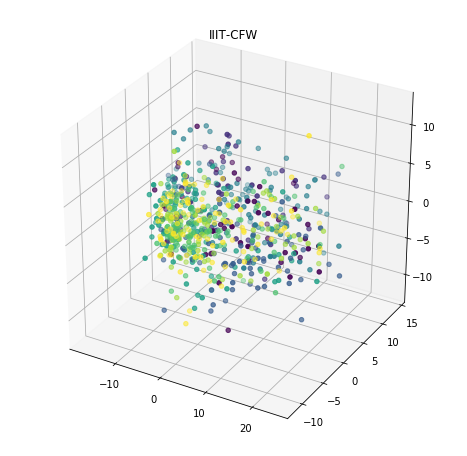

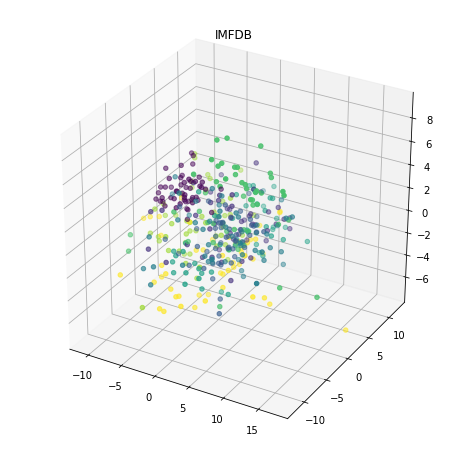

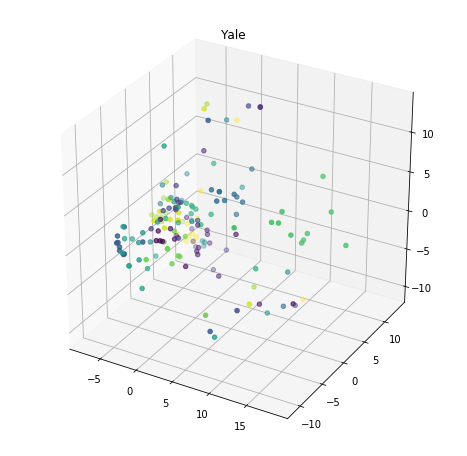

In [40]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=y)
plt.title("IIIT-CFW")

fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(X_movie_pca[:,0],X_movie_pca[:,1],X_movie_pca[:,2],c=y_movie)
plt.title("IMFDB")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_yale_pca[:,0],X_yale_pca[:,1],X_yale_pca[:,2],c=y_yale)
plt.title("Yale")

In [275]:
# Plot the eigen value spectrum 
def eigen_spectrum(X, name):
    cova = np.cov(np.transpose(X))
    print(cova.shape)
    eigval,eigvec = np.linalg.eig(cova)
    eigval=eigval.real

    mean = np.mean(eigval)
    std = np.std(eigval)
    eigval = (eigval-mean)/std

    np.sort(eigval)
    xaxis=[]
    for i in range(1,101):
        xaxis.append(i)
    plt.scatter(xaxis,eigval[:100])
    plt.plot(eigval[:100])
    plt.title(name)

(3072, 3072)


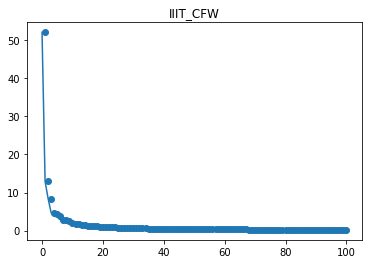

In [27]:
# For X - cartoon data set
eigen_spectrum(X, "IIIT_CFW")

(3072, 3072)


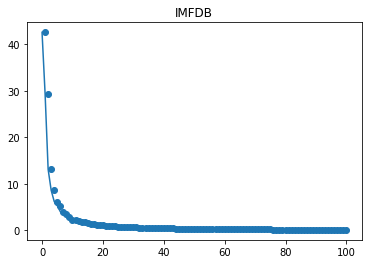

In [28]:
# For X_movie
eigen_spectrum(X_movie, "IMFDB")

(3072, 3072)


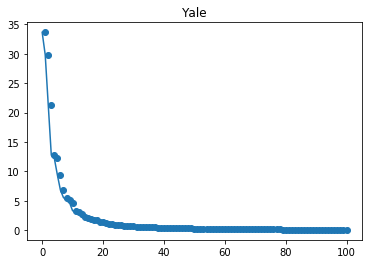

In [29]:
# For X_yale
eigen_spectrum(X_yale, "Yale")

1(c). Reconstruct  the  image  back for each case


In [276]:
def reconstruct_images(X,pca):
    reconstruct_X = pca.inverse_transform(X)
    return reconstruct_X    

In [277]:
# Display results 
def results(X, y, X_pca, pca, N, H, W, C):
    X_reconstructed = reconstruct_images(X_pca, pca)

    # Show the reconstruction error
    err = np.sqrt(np.mean((X - X_reconstructed)**2))
    X_reconstructed = X_reconstructed.reshape((N,H,W,C))

    #Display random images
    ind = np.random.randint(0,y.shape[0],6)
    disply_images(X_reconstructed[ind,...],y[ind],row=2,col=3)
    return err
rows = [] #for table

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


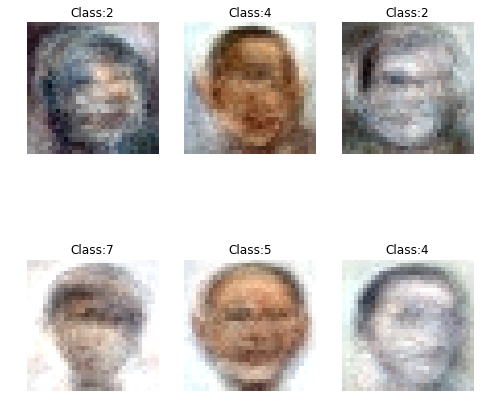

Reconstruction Error: 
 0.16701565858673606


In [278]:
# for cartoon dataset
err = results(X, y, X_pca, pca, N, H, W, C)
print("Reconstruction Error: \n", err)
row = ({'dataset': "IIIT_CFW", 'recon error': err})
rows.append(row)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


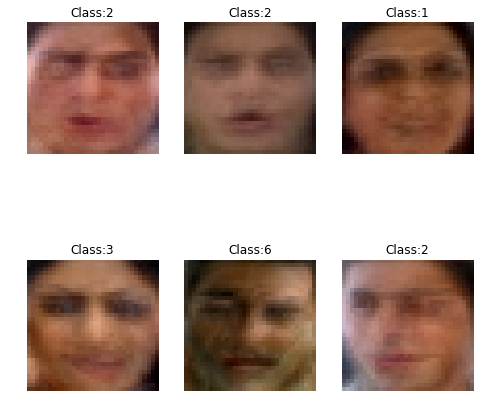

Reconstruction Error: 
 0.06421404831632327


In [279]:
# Display results for imfdb dataset 
err = results(X_movie, y_movie, X_movie_pca, pca2, N2, H2, W2, C2)
print("Reconstruction Error: \n", err)
row = ({'dataset': "IMFDB", 'recon error': err})
rows.append(row)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


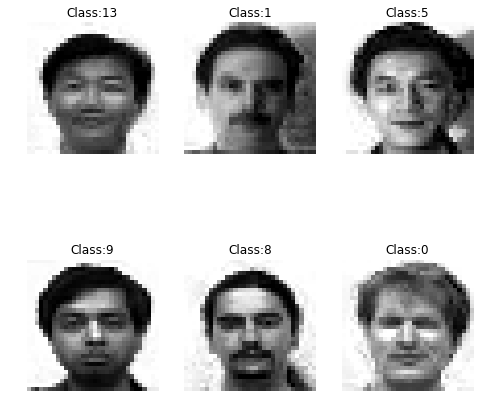

Reconstruction Error: 
 0.06683448964882872


In [280]:
# Display results for yale dataset 
err = results(X_yale, y_yale, X_yale_pca, pca3, N3, H3, W3, C3)
print("Reconstruction Error: \n", err)
row = ({'dataset': "Yale", 'recon error': err})
rows.append(row)

In [281]:
df = pd.DataFrame(data=rows, columns = ['dataset', 'recon error']) 
df.style

,dataset,recon error
0,IIIT_CFW,0.167016
1,IMFDB,0.064214
2,Yale,0.0668345


### Which person/identity is difficult to represent compactly with fewer eigen vectors?  

In [282]:
# Display results 
# a modified version of the results function above, because I don't want to print the images
def results_error(X, y, X_pca, pca, N, H, W, C):
    X_reconstructed = reconstruct_images(X_pca, pca) #reconstructing images 
    err = np.sqrt(np.mean((X - X_reconstructed)**2))
    return err

In [283]:
# code goes here
# function to compute errors for each class in a dataset
def compute_error(X,y):
    no_labels = max(y) + 1 #how many labels in each class

    length = len(y)
    errors = []
    for j in range(no_labels): # for each label 
        labels = []
        labels2 = []
        images = []
        for i in range(length): # iterate thorughout the dataset 
            if(y[i] == j): # checking the sample's label
                labels.append(i)#index
                labels2.append(y[i])#label itself!
        for i in labels:
            images.append(X[i])#image corresponding to that label 
        
        # converting to np arrays
        images = np.array(images)
        labels = np.array(labels)
        labels2 = np.array(labels2)
        
        print("Label:", j)
        N = images.shape[0]
        # compute PCA for each label 
        images_pca, pca = get_pca(images, 9)
        
        #call results function
        err = results_error(images, labels2, images_pca, pca, N, H, W, C)
        print("Reconstruction Error = ", err, "\n")
        errors.append(err)
    return errors

rows=[] #for table representation 

In [284]:
# IIIT data set 
errors = compute_error(X, y)
errors = np.array(errors)
print("Maximum error = ", max(errors))
ind = np.where(errors == max(errors)) # finding label of the max error
print ("Class label of maximum error:", ind[0][0])
row = ({'dataset': "IIIT-CFW", 'max error': max(errors).round(3), 'class label': ind[0][0] })
rows.append(row)

Label: 0
Reconstruction Error =  0.17352503390639748 

Label: 1
Reconstruction Error =  0.17821968769119628 

Label: 2
Reconstruction Error =  0.16305254136447864 

Label: 3
Reconstruction Error =  0.18419621721206791 

Label: 4
Reconstruction Error =  0.1909330667300858 

Label: 5
Reconstruction Error =  0.20956700231569486 

Label: 6
Reconstruction Error =  0.20813147162801318 

Label: 7
Reconstruction Error =  0.19547859300803014 

Maximum error =  0.20956700231569486
Class label of maximum error: 5


In [115]:
errors = compute_error(X_movie, y_movie)
errors= np.array(errors)
print("Maximum error = ", max(errors))
ind = np.where(errors == max(errors))
print ("Class label of maximum error:", ind[0][0])
row = ({'dataset': "IMFDB", 'max error': max(errors).round(3), 'class label': ind[0][0] })
rows.append(row)

Label: 0
Reconstruction Error =  0.058313945940468195 

Label: 1
Reconstruction Error =  0.07571216173100319 

Label: 2
Reconstruction Error =  0.07312769207457974 

Label: 3
Reconstruction Error =  0.08824297001672392 

Label: 4
Reconstruction Error =  0.08893951488118941 

Label: 5
Reconstruction Error =  0.08181236046153201 

Label: 6
Reconstruction Error =  0.07834465250670682 

Label: 7
Reconstruction Error =  0.09030146901880523 

Maximum error =  0.09030146901880523
Class label of maximum error: 7


In [116]:
errors = compute_error(X_yale, y_yale)
errors= np.array(errors)
print("Maximum error = ", max(errors))
ind = np.where(errors == max(errors))
print ("Class label of maximum error:", ind[0][0])
row = ({'dataset': "Yale", 'max error': max(errors).round(3), 'class label': ind[0][0] })
rows.append(row)

Label: 0
Reconstruction Error =  0.02046963166791184 

Label: 1
Reconstruction Error =  0.008593947017902042 

Label: 2
Reconstruction Error =  0.009617528683603799 

Label: 3
Reconstruction Error =  0.01078871084091831 

Label: 4
Reconstruction Error =  0.008177516422446374 

Label: 5
Reconstruction Error =  2.3567089499043977e-16 

Label: 6
Reconstruction Error =  3.7285454678825005e-16 

Label: 7
Reconstruction Error =  0.028764413795350732 

Label: 8
Reconstruction Error =  3.477284257226037e-16 

Label: 9
Reconstruction Error =  0.013500487926886464 

Label: 10
Reconstruction Error =  0.0183285926497776 

Label: 11
Reconstruction Error =  2.472888957127317e-16 

Label: 12
Reconstruction Error =  0.010959400264151826 

Label: 13
Reconstruction Error =  0.00755731855878336 

Label: 14
Reconstruction Error =  0.019052727928740208 

Maximum error =  0.028764413795350732
Class label of maximum error: 7


In [118]:
df = pd.DataFrame(data=rows, columns = ['dataset', 'max error', 'class label']) 
df.style

,dataset,max error,class label
0,IIIT-CFW,0.21,5
1,IMFDB,0.09,7
2,Yale,0.029,7


## Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

 
Reference paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .

In [285]:
class Classifier():
    def __init__(self, style):
        # Classifier types
        if (style == "mlp"):
            mlp = MLPClassifier(random_state=42)
            self.classifier = mlp
        
        if (style == "svm"):
            svm = SVC(C=10, class_weight = 'balanced' , gamma='scale', kernel='poly',coef0 = 0.01, decision_function_shape='ovo')
            self.classifier = svm
        
        if (style == "lr"):
            lr = LogisticRegression(C=0.1, class_weight = 'balanced', solver='lbfgs')
            self.classifier = lr
        
        if (style == "decision_tree"):
            dt = DecisionTreeClassifier(random_state=42)
            self.classifier = dt
    
    def classify(self,X):
        prediction = self.classifier.predict(X)
        return prediction
        
    def confusion_matrix(self,y_actual, y_predict):
        confusion = confusion_matrix(y_actual, y_predict)
        return confusion
        
        
    def train(self,X_train,y_train):
        self.classifier.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        y_predict = self.classify(X_validate)
        y_actual = y_validate 

        # Create a confusion matrix
        self.confusion = self.confusion_matrix(y_actual, y_predict)
        
        # Calculate Validation accuracy 
        self.accuracy = accuracy_score(y_actual, y_predict)
        self.accuracy = self.accuracy * 100
        
        self.error_clf = 100 - self.accuracy 
        
        # Calculate precision and recall
        self.precision = precision_score(y_actual, y_predict, average='micro')
        self.recall = recall_score(y_actual, y_predict, average='micro')
        
        # Calculate F1-score
        self.f1 = f1_score(y_actual, y_predict, average ='macro')
        
        try:
            self.report = classification_report(y_actual, y_predict)
        except:
            pass
    
        return 

In [286]:
# This loads the data from the dataset, modified version of load_data
# It returns the train and test data after loading X and y from the dataset and flattening it 
def load(dataset):
    X,y = load_data(dataset)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]

    #flattening the data
    X = X.reshape((N,H*W*C))
    return X,y

In [287]:
#applies a classifier on the dataset and returns scores and results in row_dict
def classify_data(cl, X_train, Y_train, X_test, Y_test, feature):
    obj = Classifier(cl)
    obj.train(X_train,Y_train)
    obj.validate(X_test,Y_test)
    row_dict = ({'dataset': dataset_name, 'classifier': cl, 'error': obj.error_clf, 'accuracy': obj.accuracy, 'f1-score': obj.f1, 'features': feature })
    return row_dict

In [288]:
# Create a train and validation split to train your classifier 
classifiers = ["lr","mlp","decision_tree","svm"]
datasets = [dirpath, dirpath2, dirpath3]
dataset_names = ["IIIT-CFW", "IMFDB", "Yale"]
tables=[]

for ind, dataset in enumerate(datasets):
    dataset_name = dataset_names[ind]
    
    X,y = load(dataset)
    X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.20,random_state=1)
    
    rows=[]
    for cl in classifiers:
        row_dict = classify_data(cl, X_train, Y_train, X_test, Y_test, "none")
        rows.append(row_dict)

    df = pd.DataFrame(data=rows, columns = ['dataset', 'classifier', 'error', 'accuracy', 'f1-score', 'features']) 
    tables.append(df)
    
df1 = tables[0]
df2 = tables[1]
df3 = tables[2]       

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


## IIIT Cartoon Dataset

In [289]:
df1.style

,dataset,classifier,error,accuracy,f1-score,features
0,IIIT-CFW,lr,32.5926,67.4074,0.641763,none
1,IIIT-CFW,mlp,41.4815,58.5185,0.553334,none
2,IIIT-CFW,decision_tree,63.7037,36.2963,0.336016,none
3,IIIT-CFW,svm,38.5185,61.4815,0.577631,none


## IMFDB Dataset

In [290]:
df2.style

,dataset,classifier,error,accuracy,f1-score,features
0,IMFDB,lr,17.5,82.5,0.819683,none
1,IMFDB,mlp,15,85,0.844817,none
2,IMFDB,decision_tree,51.25,48.75,0.484686,none
3,IMFDB,svm,16.25,83.75,0.835736,none


## Yale Dataset

In [130]:
df3.style

,dataset,classifier,error,accuracy,f1-score,features
0,Yale,lr,6.06061,93.9394,0.896145,none
1,Yale,mlp,0,100,1,none
2,Yale,decision_tree,30.303,69.697,0.671769,none
3,Yale,svm,15.1515,84.8485,0.804082,none


## Applying Logistic Regression to classify data
### But the data is feature transformed!

In [291]:
#applies a classifier on the dataset and returns scores and results in row_dict
def classify_data2(cl, X_train, Y_train, X_test, Y_test, feature):
    obj = Classifier(cl)
    obj.train(X_train,Y_train)
    obj.validate(X_test,Y_test)
    row_dict = ({'dataset': dataset_name, 'classifier': cl, 'error': obj.error_clf, 'accuracy': obj.accuracy, 'f1-score': obj.f1, 'features': feature, 'dimensions': X_train.shape[1]})
    confusion = obj.confusion
    return row_dict, confusion

In [292]:
#Let's use logistic regression to classify the data in all datasets! 
#And apply different combination of features!
tables2=[]
matrices = []

for ind, dataset in enumerate(datasets):
    rows = []
    dataset_name = dataset_names[ind]
    X,y = load(dataset)
    
    #Now let's apply different feature transformations to the flattened data  
    X_pca,_ = get_pca(X,60)
    X_kpca = get_kernel_pca(X,60,kernel='rbf')
    X_lda = get_lda(X,y,60)
    X_klda = get_kernel_lda(X,y,60,kernel='rbf')
    X_vgg = get_vgg_features(dataset)
    X_res = get_resnet_features(dataset)
    
    #Now let's use logistic regression to classify the feature transformed images
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "pca")
    rows.append(row_dict)
    matrices.append(confusion)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_kpca, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "kernel pca")
    rows.append(row_dict)
    matrices.append(confusion)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_lda, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "lda")
    rows.append(row_dict)
    matrices.append(confusion)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_klda, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "kernel lda")
    rows.append(row_dict)
    matrices.append(confusion)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_vgg, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "vgg")
    rows.append(row_dict)
    matrices.append(confusion)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_res, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "res vgg")
    rows.append(row_dict)
    matrices.append(confusion)
    
    df = pd.DataFrame(data=rows, columns = ['dataset', 'classifier', 'error', 'accuracy', 'f1-score', 'features', 'dimensions']) 
    tables2.append(df)

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


### IIIT Cartoon dataset

In [228]:
df = tables2[0]
df.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,IIIT-CFW,lr,39.2593,60.7407,0.571566,pca,60
1,IIIT-CFW,lr,50.3704,49.6296,0.480819,kernel pca,60
2,IIIT-CFW,lr,5.18519,94.8148,0.94161,lda,7
3,IIIT-CFW,lr,5.18519,94.8148,0.94161,kernel lda,7
4,IIIT-CFW,lr,23.7037,76.2963,0.718714,vgg,4096
5,IIIT-CFW,lr,1.48148,98.5185,0.988306,res vgg,2048


### IMFDB dataset

In [229]:
new1 = tables2[1]
new1.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,IMFDB,lr,20,80,0.790543,pca,60
1,IMFDB,lr,36.25,63.75,0.615479,kernel pca,60
2,IMFDB,lr,3.75,96.25,0.959571,lda,7
3,IMFDB,lr,3.75,96.25,0.959571,kernel lda,7
4,IMFDB,lr,8.75,91.25,0.908383,vgg,4096
5,IMFDB,lr,3.75,96.25,0.955787,res vgg,2048


### Yale dataset

In [230]:
df = tables2[2]
df.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,Yale,lr,6.06061,93.9394,0.896145,pca,60
1,Yale,lr,21.2121,78.7879,0.751701,kernel pca,60
2,Yale,lr,0,100,1,lda,14
3,Yale,lr,0,100,1,kernel lda,14
4,Yale,lr,39.3939,60.6061,0.552891,vgg,4096
5,Yale,lr,0,100,1,res vgg,2048


## Now let's do it for different combinations of feature transforms, with different classifiers

In [244]:
#Let's use different classifiers to classify the data in all datasets! 
#And apply different combination of features!
tables3=[]
matrices = []

for ind, dataset in enumerate(datasets):
    rows = []
    dataset_name = dataset_names[ind]
    X,y = load(dataset)
    
    X_pca,_ = get_pca(X,3)
    X_kpca = get_kernel_pca(X,60,kernel='rbf')
    X_lda = get_lda(X,y,60)
    X_klda = get_kernel_lda(X,y,60,kernel='rbf')
    X_vgg = get_vgg_features(dataset)
    X_res = get_resnet_features(dataset)
    
    # all features and MLP classification
    X_all = np.concatenate((X_pca,X_kpca,X_lda,X_klda,X_vgg,X_res),axis=1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("mlp", X_train, Y_train, X_test, Y_test, "all")
    rows.append(row_dict)
    matrices.append(confusion)
    
     # VGG + Resnet, LR 
    X_new = np.concatenate((X_vgg,X_res),axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "vgg+res")
    rows.append(row_dict)
    
    # LDA + resnet
    X_new = np.concatenate((X_lda,X_res),axis=1) 
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "lda + resnet")
    rows.append(row_dict)

    
    #Resnet, MLP   
    X_train, X_test, Y_train, Y_test = train_test_split(X_res, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("mlp", X_train, Y_train, X_test, Y_test, "resnet")
    rows.append(row_dict)
    
    #LDA + PCA, LR 
    X_new = np.concatenate((X_pca,X_lda),axis=1)    
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("lr", X_train, Y_train, X_test, Y_test, "lda + pca")
    rows.append(row_dict)

    
    #LDA + PCA, svm
    X_new = np.concatenate((X_pca,X_lda),axis=1)    
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size=0.20, random_state=1)
    row_dict, confusion = classify_data2("svm", X_train, Y_train, X_test, Y_test, "lda + pca")
    rows.append(row_dict)

    
    df = pd.DataFrame(data=rows, columns = ['dataset', 'classifier', 'error', 'accuracy', 'f1-score', 'features', 'dimensions']) 
    tables3.append(df)

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


In [245]:
df3 = tables3[0]
df3.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,IIIT-CFW,mlp,0.740741,99.2593,0.994681,all,6221
1,IIIT-CFW,lr,0,100,1,vgg+res,6144
2,IIIT-CFW,lr,0.740741,99.2593,0.994681,lda + resnet,2055
3,IIIT-CFW,mlp,2.22222,97.7778,0.975438,resnet,2048
4,IIIT-CFW,lr,5.92593,94.0741,0.926702,lda + pca,10
5,IIIT-CFW,svm,8.14815,91.8519,0.904566,lda + pca,10


In [246]:
df3 = tables3[1]
df3.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,IMFDB,mlp,0,100,1,all,6221
1,IMFDB,lr,0,100,1,vgg+res,6144
2,IMFDB,lr,0,100,1,lda + resnet,2055
3,IMFDB,mlp,3.75,96.25,0.955787,resnet,2048
4,IMFDB,lr,2.5,97.5,0.974391,lda + pca,10
5,IMFDB,svm,2.5,97.5,0.971412,lda + pca,10


In [247]:
df3 = tables3[2]
df3.style

,dataset,classifier,error,accuracy,f1-score,features,dimensions
0,Yale,mlp,0,100,1,all,6235
1,Yale,lr,0,100,1,vgg+res,6144
2,Yale,lr,0,100,1,lda + resnet,2062
3,Yale,mlp,3.0303,96.9697,0.958974,resnet,2048
4,Yale,lr,0,100,1,lda + pca,17
5,Yale,svm,9.09091,90.9091,0.865986,lda + pca,17


In [248]:
print(matrices[0])

[[ 7  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  1]
 [ 0  0  0 26  0  0  0  0]
 [ 0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0 23]]


In [249]:
print(matrices[1])

[[10  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0]
 [ 0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0 10]]


In [250]:
print(matrices[2])

[[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4]]


## t-SNE based visilization of faces

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


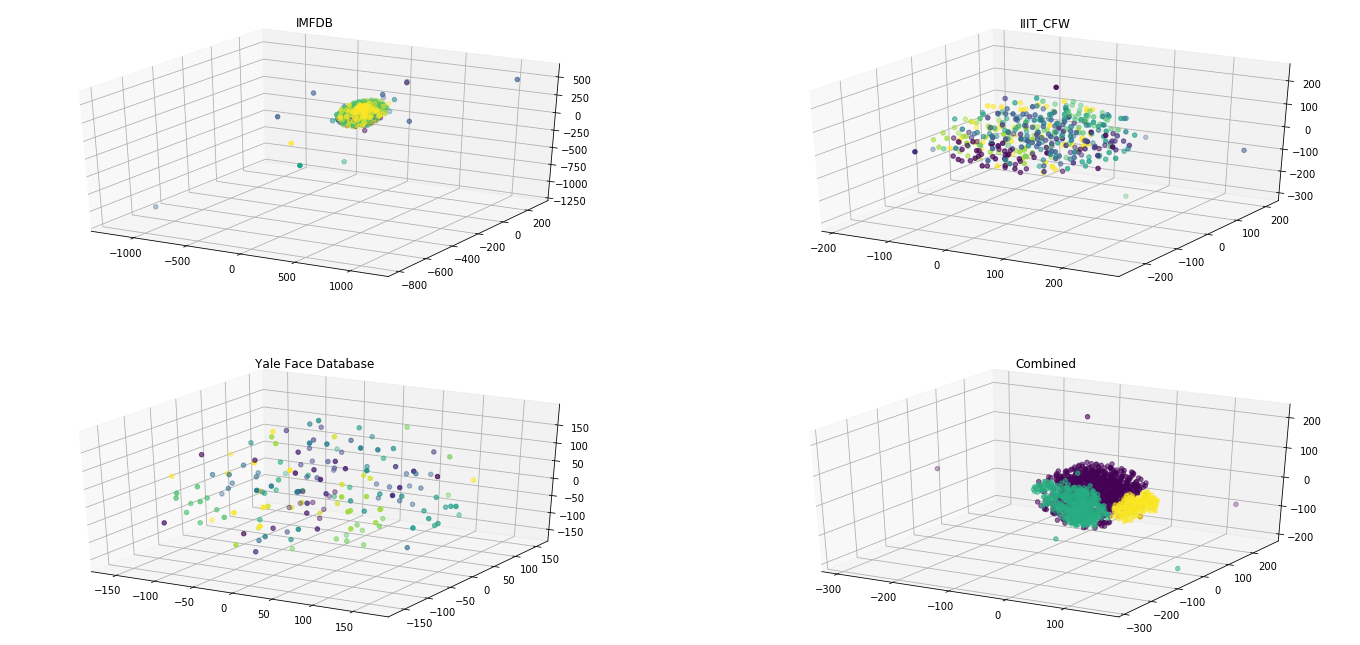

In [179]:
# Compute TSNE for different features and create a scatter plot
X,y = load(dirpath)
X_movie,y_movie = load(dirpath2)
X_yale,y_yale = load(dirpath3)
combined = np.concatenate((X, X_movie, X_yale))

y1 = y.shape[0]
y2 = y_movie.shape[0]

labels2 = y_movie + y1
labels3 = y_yale + y1 + y2
combined_y = np.concatenate((y, labels2, labels3))

fig = plt.figure(figsize = (24, 24))

# X =  # features 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)
X_movie_TSNE = TSNE(n_components=k).fit_transform(X_movie)
X_yale_TSNE = TSNE(n_components=k).fit_transform(X_yale)
combined_TSNE = TSNE(n_components=k).fit_transform(combined)

ax = fig.add_subplot("421", projection = "3d")
ax.scatter(X_TSNE[:, 0], X_TSNE[:, 1], X_TSNE[:, 2], c = y)
ax.set_title("IMFDB")

ax = fig.add_subplot("422", projection = "3d")
ax.scatter(X_movie_TSNE[:, 0], X_movie_TSNE[:, 1], X_movie_TSNE[:, 2], c = y_movie)
ax.set_title("IIIT_CFW")

ax = fig.add_subplot("423", projection = "3d")
ax.scatter(X_yale_TSNE[:, 0], X_yale_TSNE[:, 1], X_yale_TSNE[:, 2], c = y_yale)
ax.set_title("Yale Face Database")

ax = fig.add_subplot("424", projection = "3d")
ax.scatter(combined_TSNE[:, 0], combined_TSNE[:, 1], combined_TSNE[:, 2], c = combined_y)
ax.set_title("Combined")


k = 2 # Number of components in TSNE
X_TSNE = TSNE(n_components=k).fit_transform(X)
X_movie_TSNE = TSNE(n_components=k).fit_transform(X_movie)
X_yale_TSNE = TSNE(n_components=k).fit_transform(X_yale)
combined_TSNE = TSNE(n_components=k).fit_transform(combined)

# ax = fig.add_subplot("425")
# ax.scatter(X_TSNE[:, 0], X_TSNE[:, 1], c = y)
# ax.set_title("IMFDB")

# ax = fig.add_subplot("426")
# ax.scatter(X_movie_TSNE[:, 0], X_movie_TSNE[:, 1], c = y_movie)
# ax.set_title("IIIT_CFW")

# ax = fig.add_subplot("427")
# ax.scatter(X_yale_TSNE[:, 0], X_yale_TSNE[:, 1], c = y_yale)
# ax.set_title("Yale Face Database")

# ax = fig.add_subplot("428")
# ax.scatter(combined_TSNE[:, 0], combined_TSNE[:, 1], c = combined_y)
# ax.set_title("Combined")
# Plot the representation in 2d/3d

How do we formulate the problem using KNN ?

In [212]:
class FaceVerification():
    def __init__(self,k):
        self.knn = KNN(n_neighbors = k)
        #super.__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        predictions = self.knn.predict(X)
        verification_results = predictions == class_id
        return verification_results
        
    def train(self,X_train,y_train):
        self.knn.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        y_predict = self.knn.predict(X_validate)
        y_actual = y_validate
        
#         total = np.sum (predictions == y_validate)
#         accuracy = 100*total/X_validate.shape[0]
        
        self.accuracy = 100*accuracy_score(y_actual, y_predict)
        self.error_clf = 100 - self.accuracy
        self.precision = precision_score(y_actual, y_predict, average='micro')
        self.f1 = f1_score(y_actual, y_predict, average ='macro')
        
        return

In [213]:
#applies a classifier on the dataset and returns scores and results in row_dict
def classify_data3(cl, X_train, Y_train, X_test, Y_test, feature):
    obj = FaceVerification(cl)
    obj.train(X_train,Y_train)
    obj.validate(X_test,Y_test)
    row_dict = ({'dataset': dataset_name, 'k': cl, 'error': obj.error_clf, 'accuracy': obj.accuracy, 'f1-score': obj.f1, 'features': feature})
    confusion = 1
    return row_dict, confusion

In [219]:
# Create a train and validation split and show your results 
# classifiers = ["lr","mlp","decision_tree","svm"]
# datasets = [dirpath, dirpath2, dirpath3]
# dataset_names = ["IIIT-CFW", "IMFDB", "Yale"]
tables2=[]
matrices = []
kvals = [3,7]

for ind, dataset in enumerate(datasets):
    for k in kvals:
        rows = []
        dataset_name = dataset_names[ind]
        X,y = load(dataset)

        #Now let's apply different feature transformations to the flattened data  
        X_pca,_ = get_pca(X,3)
        X_kpca = get_kernel_pca(X,60,kernel='rbf')
        X_lda = get_lda(X,y,60)
        X_klda = get_kernel_lda(X,y,60,kernel='rbf')
        X_vgg = get_vgg_features(dataset)
        X_res = get_resnet_features(dataset)

        #Now let's use logistic regression to classify the feature transformed images
        X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "pca")
        rows.append(row_dict)
        matrices.append(confusion)

        X_train, X_test, Y_train, Y_test = train_test_split(X_kpca, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "kernel pca")
        rows.append(row_dict)
        matrices.append(confusion)

        X_train, X_test, Y_train, Y_test = train_test_split(X_lda, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "lda")
        rows.append(row_dict)
        matrices.append(confusion)

        X_train, X_test, Y_train, Y_test = train_test_split(X_klda, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "kernel lda")
        rows.append(row_dict)
        matrices.append(confusion)

        X_train, X_test, Y_train, Y_test = train_test_split(X_vgg, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "vgg")
        rows.append(row_dict)
        matrices.append(confusion)

        X_train, X_test, Y_train, Y_test = train_test_split(X_res, y, test_size=0.20, random_state=1)
        row_dict, confusion = classify_data3(k, X_train, Y_train, X_test, Y_test, "res vgg")
        rows.append(row_dict)
        matrices.append(confusion)

        df = pd.DataFrame(data=rows, columns = ['dataset', 'k', 'error', 'accuracy', 'f1-score', 'features']) 
        tables2.append(df)      

Dataset shape: (672, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


In [222]:
x1 = tables2[0]
x1.style

,dataset,k,error,accuracy,f1-score,features
0,IIIT-CFW,3,72.5926,27.4074,0.273124,pca
1,IIIT-CFW,3,55.5556,44.4444,0.422343,kernel pca
2,IIIT-CFW,3,5.18519,94.8148,0.939516,lda
3,IIIT-CFW,3,5.18519,94.8148,0.939516,kernel lda
4,IIIT-CFW,3,30.3704,69.6296,0.625355,vgg
5,IIIT-CFW,3,2.96296,97.037,0.961466,res vgg


In [223]:
x1 = tables2[1]
x1.style

,dataset,k,error,accuracy,f1-score,features
0,IIIT-CFW,7,69.6296,30.3704,0.309277,pca
1,IIIT-CFW,7,54.0741,45.9259,0.412098,kernel pca
2,IIIT-CFW,7,5.92593,94.0741,0.935859,lda
3,IIIT-CFW,7,5.92593,94.0741,0.935859,kernel lda
4,IIIT-CFW,7,28.8889,71.1111,0.627012,vgg
5,IIIT-CFW,7,2.22222,97.7778,0.976283,res vgg


### Extension / Application
- cartoon vs real images: Using a combination of IIIT-CFW and other dataset. 

In [251]:
# a modified function of classify_data, that returns confusion matrix and report
def classify_data(cl, X_train, Y_train, X_test, Y_test, feature):
    obj = Classifier(cl)
    obj.train(X_train,Y_train)
    obj.validate(X_test,Y_test)
    row_dict = ({'dataset': dataset_name, 'classifier': cl, 'accuracy': obj.accuracy, 'f1-score': obj.f1, 'features': feature })
    return row_dict, obj.report, obj.confusion

In [252]:
# Load data
# Let's conjoin the cartoon and real person data sets, and have two labels, one for each 

X_animated,y_animated = load_data(dirpath)
X_movie, y_movie = load_data(dirpath2)
X_yale, y_yale = load_data(dirpath3)

y_animated[y_animated>=0] = 0
y_movie[y_movie>=0] = 1
y_yale[y_yale>=0] = 1

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


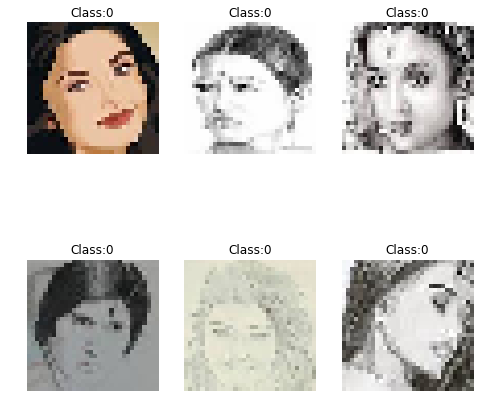

In [253]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_animated[ind,...],y_animated[ind], row=2,col=3)

In [254]:
# Define your features
X_real = np.concatenate((X_movie,X_yale))
y_real = np.concatenate((y_movie,y_yale))

images = np.concatenate((X_animated, X_real))
labels = np.concatenate((y_animated, y_real))

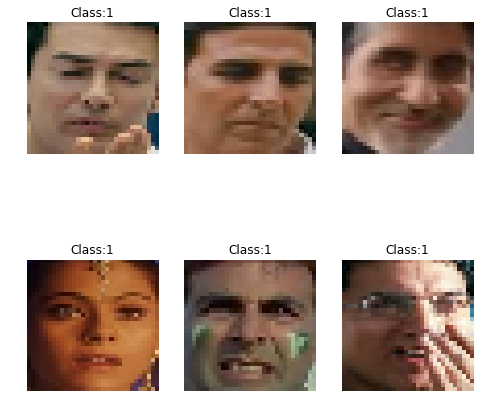

In [255]:
disply_images(X_real[ind,...],y_real[ind], row=2,col=3)

In [257]:
def modified_pca(X,k):
    pca = PCA(n_components=k)
    pca_fit = pca.fit(X,y)
    X_k = pca.fit_transform(X)
    return X_k, pca_fit 

In [259]:
# splitting into train and test
X_train, X_test, Y_train, Y_test = train_test_split(images,labels,stratify=labels,test_size=0.20,random_state=1)
print(images.shape)
N,H,W,C = X_train.shape
X_train = X_train.reshape((N,H*W*C))

N,H,W,C = X_test.shape
X_test = X_test.reshape((N,H*W*C))

#now we apply pca to train set, to bring it down from 3072 dimensions to 3 dimensions
X_train_pca, pca = modified_pca(X_train,60)
X_test_pca = pca.transform(X_test)

# Now let's use MLP classifier to classify this data!
row_dict, report, confusion = classify_data("mlp", X_train_pca, Y_train, X_test_pca, Y_test, "pca")
print(report)
print(confusion)
print(row_dict)

(1237, 32, 32, 3)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       135
           1       0.96      1.00      0.98       113

    accuracy                           0.98       248
   macro avg       0.98      0.98      0.98       248
weighted avg       0.98      0.98      0.98       248

[[130   5]
 [  0 113]]
{'dataset': 'Yale', 'classifier': 'mlp', 'accuracy': 97.98387096774194, 'f1-score': 0.9797435269133382, 'features': 'pca'}


In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_animated[ind,...],y_animated[ind], row=2,col=3)